In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.functional import F

from matplotlib import pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
DEVICE

'cpu'

## Loading data

In [37]:
data = pd.read_csv('data.csv')
data.tail()

,Unnamed: 0,data,#1 GFlop/s,#500 GFlop/s,Sum GFlop/s
50,50,06/2018,122300000.0,715551.0,1.210915e+09
51,51,11/2018,143500000.0,874800.0,1.414956e+09
52,52,06/2019,148600000.0,1021000.0,1.559575e+09
53,53,11/2019,148600000.0,1142000.0,1.646887e+09
54,54,06/2020,415530000.0,1228000.0,2.206134e+09


In [46]:
# create x axis in months from 1993
x = data['data'].to_numpy()
x = [el.split('/') for el in x]
x = [(int(el[1]) - 1993)*12 + int(el[0]) for el in x]

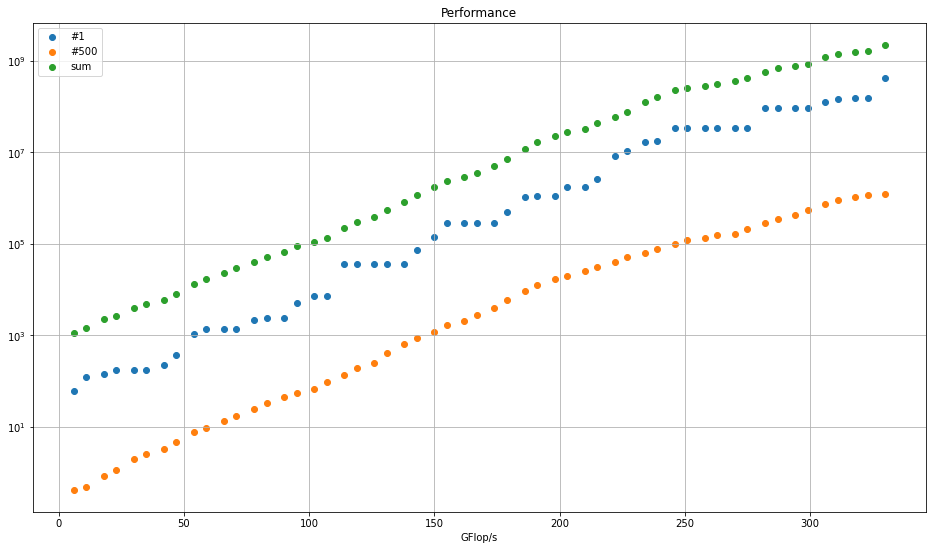

In [47]:
plt.figure(figsize=(16,9))
plt.scatter(x, data['#1 GFlop/s'], label='#1')
plt.scatter(x, data['#500 GFlop/s'], label='#500')
plt.scatter(x, data['Sum GFlop/s'], label='sum')

plt.xlabel('months from 1993')
plt.xlabel('GFlop/s')
plt.grid()
plt.title('Performance')
plt.legend()
plt.yscale('log')

## Create simple PyTorch model

In [162]:
class SimpleModel(nn.Module):
    
    def __init__(self, n_input, n_hidden):
        super(SimpleModel, self).__init__()
        self.lin1 = nn.Linear(n_input, n_hidden)
#         self.lin2 = nn.Linear(n_hidden, n_hidden)
        self.lin2 = nn.Linear(n_hidden,1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
#         x = self.lin2(x)
#         x = F.relu(x)

        output = self.lin2(x)
        return output

def train(model, X, y, loss_func, optimizer, epochs=10, device='cpu'):
    train_loss = []
    for ep_num in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_func(preds, y)
        train_loss.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        
        plt.plot(list(range(ep_num+1)), train_loss)
    return train_loss
        

In [163]:
# Scale data
scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaler_y_500 = StandardScaler()

# for top1
X = np.array(x).reshape(-1,1)
X = scaler_x.fit_transform(X)

y = np.log(np.array(data['#1 GFlop/s'])).reshape(-1,1)
y = scaler_y.fit_transform(y)

# for top500
y_500 = np.log(np.array(data['#500 GFlop/s'])).reshape(-1,1)
y_500 = scaler_y_500.fit_transform(y_500)

 16%|█▌        | 32/200 [00:00<00:00, 314.43it/s]

Top1 loss 0.0046307384


100%|██████████| 200/200 [00:00<00:00, 423.13it/s]


Top1 loss 0.0007001912


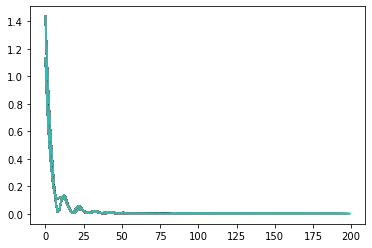

In [164]:
X = torch.tensor(X, dtype=torch.float).to(DEVICE)
y = torch.tensor(y, dtype=torch.float).to(DEVICE)
y_500 = torch.tensor(y_500, dtype=torch.float).to(DEVICE)

loss_func = nn.MSELoss()

model = SimpleModel(1, 10).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=0.05)

losses = train(model, X, y, loss_func, optim, epochs=200)
print('Top1 loss', losses[-1])

model_500 = SimpleModel(1, 10).to(DEVICE)
optim_500 = torch.optim.Adam(model_500.parameters(), lr=0.05)

losses_500 = train(model_500, X, y_500, loss_func, optim_500, epochs=200)
print('Top1 loss', losses_500[-1])

## Predictions for Top #1 and Top #500

In [165]:
# Predictions for 2025
x_new = [el*6 for el in list(range(1,11))]
x_new = np.array([el+330 for el in x_new]).reshape(-1,1)

x_new_scaled = scaler_x.transform(x_new)
x_new_scaled = torch.tensor(x_new_scaled, dtype=torch.float)

model.eval()
preds_new = model(x_new_scaled).detach().cpu().numpy()
result_new = scaler_y.inverse_transform(preds_new)
result_new = np.exp(result_new)

model_500.eval()
preds_new_500 = model_500(x_new_scaled).detach().cpu().numpy()
result_new_500 = scaler_y_500.inverse_transform(preds_new_500)
result_new_500 = np.exp(result_new_500)

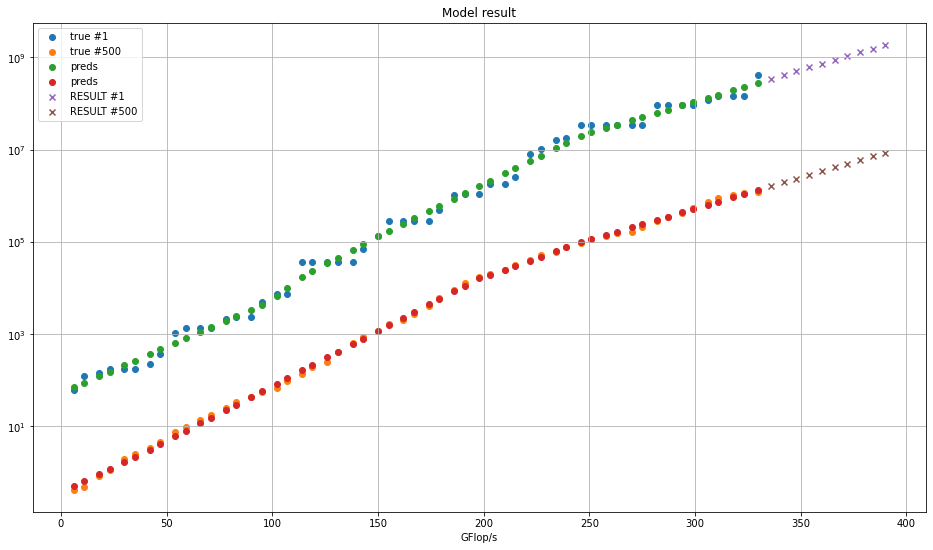

In [166]:
preds = model(X).detach().cpu().numpy()
result = scaler_y.inverse_transform(preds)
result = np.exp(result)

preds_500 = model_500(X).detach().cpu().numpy()
result_500 = scaler_y_500.inverse_transform(preds_500)
result_500 = np.exp(result_500)

plt.figure(figsize=(16,9))
plt.scatter(x, data['#1 GFlop/s'], label='true #1')
plt.scatter(x, data['#500 GFlop/s'], label='true #500')

plt.scatter(x, result, label='preds')
plt.scatter(x, result_500, label='preds')

plt.scatter(x_new, result_new, label='RESULT #1', marker='x')
plt.scatter(x_new, result_new_500, label='RESULT #500', marker='x')

plt.yscale('log')
plt.xlabel('months from 1993')
plt.xlabel('GFlop/s')
plt.grid()
plt.title('Model result')
plt.legend()
plt.show()

# Rescale results

In [167]:
x_months = 1993 + x_new / 12

table = []
for i in range(len(x_months)):
    l = [x_months[i], result_new[i], result_new_500[i]]
    table.append(l)

headers = ['year', 'Top #1,GFlop/s', 'Top #500, GFlop/s']
print(tabulate(table, headers, tablefmt="github", numalign="right"))


|   year |   Top #1,GFlop/s |   Top #500, GFlop/s |
|--------|------------------|---------------------|
|   2021 |      3.43436e+08 |         1.61156e+06 |
| 2021.5 |      4.14862e+08 |          1.9424e+06 |
|   2022 |      5.01143e+08 |         2.34116e+06 |
| 2022.5 |      6.05368e+08 |         2.82179e+06 |
|   2023 |       7.3127e+08 |         3.40109e+06 |
| 2023.5 |      8.83356e+08 |         4.09932e+06 |
|   2024 |      1.06707e+09 |         4.94088e+06 |
| 2024.5 |        1.289e+09 |         5.95522e+06 |
|   2025 |      1.55708e+09 |         7.17779e+06 |
| 2025.5 |      1.88091e+09 |         8.65136e+06 |


So my guess is that by 2024 (pessimistic - by 2025) the top1 supercomputer will reach 1EFlop/s.
At the same time, the top500 will still not reach 10 PFlop/s